In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [4]:
SEASON = '23'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [12]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [13]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= int(SEASON)-4) & (df.Season <= int(SEASON))]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [14]:
add_datepart(df, 'Date');

In [15]:
# Time-weighted
df['weight'] = np.exp(-(df.Elapsed.max() - df.Elapsed) / (3600*24*365) / df.Year.nunique())
df['weight'] = df['weight'] / df['weight'].mean()

In [16]:
procs = [Categorify, FillMissing, Normalize]

In [17]:
valid_idx = list(df.query(f'Season == {SEASON}').index)

In [18]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [19]:
splits

((#17401) [0,1,2,3,4,5,6,7,8,9...],
 (#1027) [1224,1225,1226,1227,1228,1229,1230,1231,1232,1233...])

In [20]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam']
# cont_names = list(df.columns[df.columns.str.contains('Avg')])

In [21]:
cont_names = [
    'HSLast5Avg', 
    'HCLast5Avg', 
    'ASLast5Avg', 
    'ACLast5Avg', 
    'HomeSForLast5Avg', 
    # 'HomeCForLast5Avg', 
    'AwaySForLast5Avg', 
    # 'AwayCForLast5Avg',
    'HomeSAgainstLast5Avg', 
    # 'HomeCAgainstLast5Avg', 
    'AwaySAgainstLast5Avg', 
    # 'AwayCAgainstLast5Avg',
]

In [22]:
y_block = RegressionBlock(n_out=2)

In [23]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
6148,E1,Burnley,Coventry,1.0,0.0,10.0,8.0,5.0,0.0,3.0,...,5,14,False,False,False,False,False,False,1.673654e+09,1.277566
7042,E2,Plymouth,Swindon,4.0,2.0,23.0,7.0,11.0,5.0,3.0,...,1,308,False,False,False,False,False,False,1.604362e+09,0.823250
12296,I1,Udinese,Verona,2.0,0.0,14.0,5.0,8.0,1.0,10.0,...,6,38,False,False,False,False,False,False,1.612656e+09,0.867715
7774,E2,Sheffield Weds,Plymouth,4.0,2.0,22.0,3.0,7.0,2.0,8.0,...,5,15,False,False,False,False,False,False,1.642205e+09,1.046556
15093,SP1,Valencia,Celta,1.0,0.0,9.0,11.0,5.0,4.0,4.0,...,5,32,False,True,False,False,False,False,1.580515e+09,0.707705
15141,SP1,Barcelona,Sociedad,1.0,0.0,13.0,9.0,6.0,1.0,4.0,...,5,67,False,False,False,False,False,False,1.583539e+09,0.721408
10436,F2,Rodez,Nancy,1.0,1.0,15.0,6.0,2.0,2.0,6.0,...,4,38,False,False,False,False,False,False,1.581034e+09,0.710035
9692,F1,Nantes,Angers,1.0,1.0,24.0,10.0,7.0,3.0,14.0,...,6,107,False,False,False,False,False,False,1.650154e+09,1.100666
13017,I1,Verona,Cremonese,2.0,0.0,9.0,15.0,4.0,5.0,3.0,...,0,9,False,False,False,False,False,False,1.673222e+09,1.274071
13949,I2,Vicenza,Empoli,0.0,2.0,10.0,17.0,2.0,8.0,4.0,...,5,72,False,False,False,False,False,False,1.615594e+09,0.884032


In [24]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [25]:
to.cat_names, to.cont_names

((#3) ['Div','HomeTeam','AwayTeam'],
 (#8) ['HSLast5Avg','HCLast5Avg','ASLast5Avg','ACLast5Avg','HomeSForLast5Avg','AwaySForLast5Avg','HomeSAgainstLast5Avg','AwaySAgainstLast5Avg'])

In [26]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
18426,11,138,10,-0.903637,-2.112438,-0.781309,0.105484,-0.775689,-1.506533,-0.238964,0.054991
18427,11,141,94,1.236937,-0.033191,-1.489300,-1.286588,1.027280,-1.209205,0.639287,-1.121352


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [27]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [28]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [29]:
X_train.shape, y_train.shape

((17401, 11), (17401, 2))

In [30]:
X_test.shape, y_test.shape

((1027, 11), (1027, 2))

## LightGBM

In [31]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [32]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [33]:
import lightgbm as lgbm

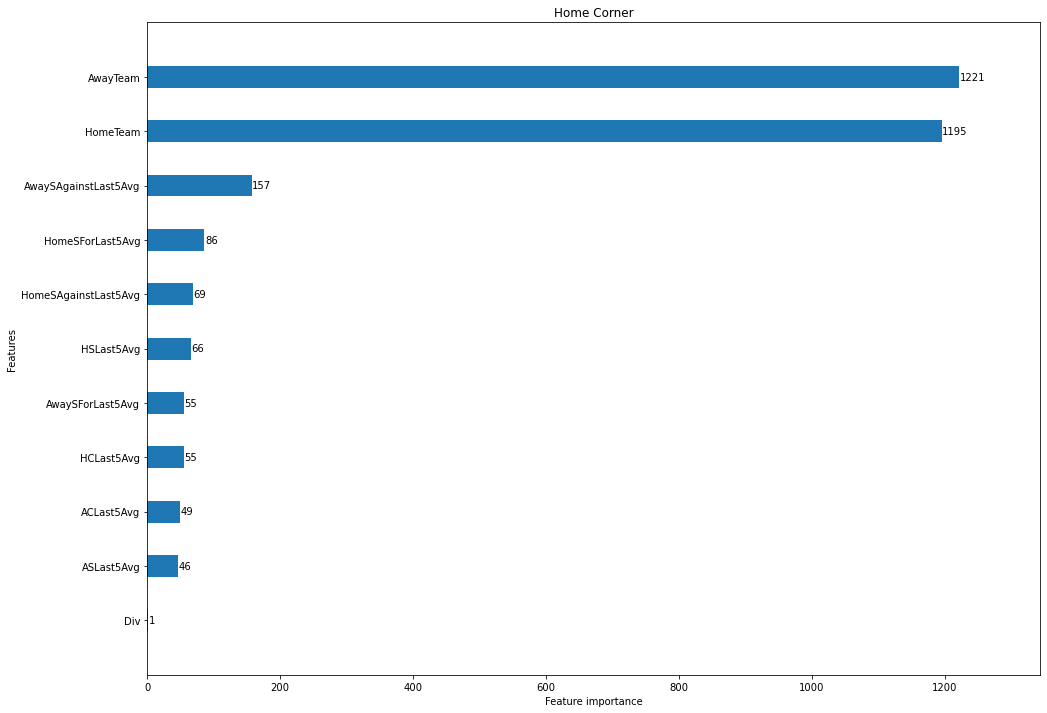

In [34]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

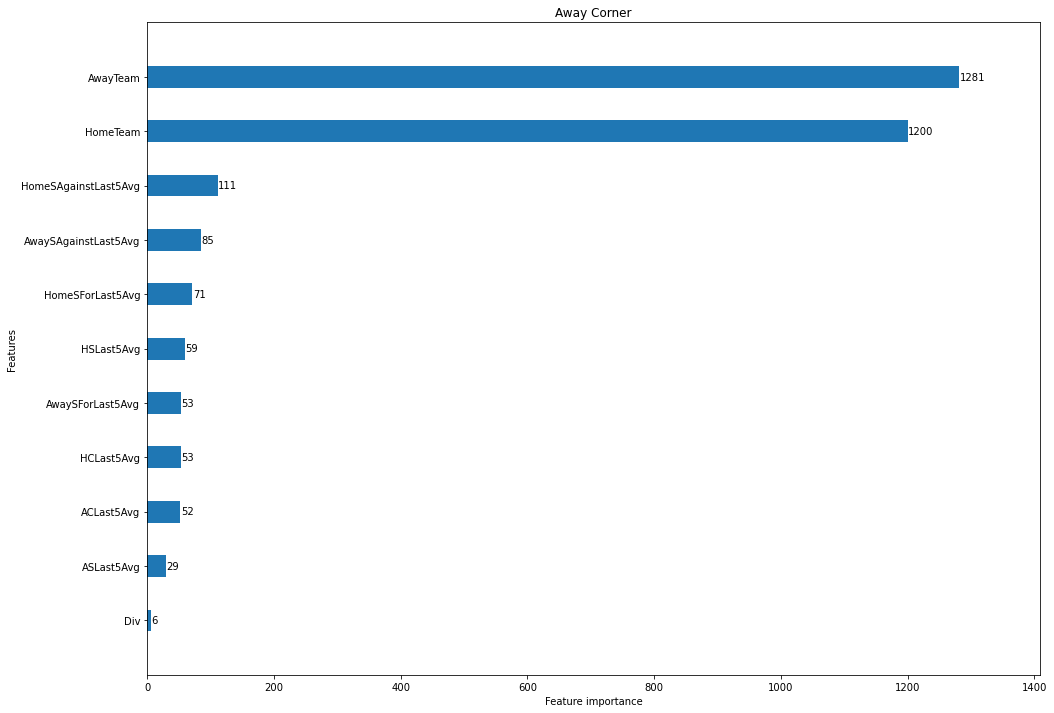

In [35]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [36]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [37]:
import xgboost as xgb

In [38]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

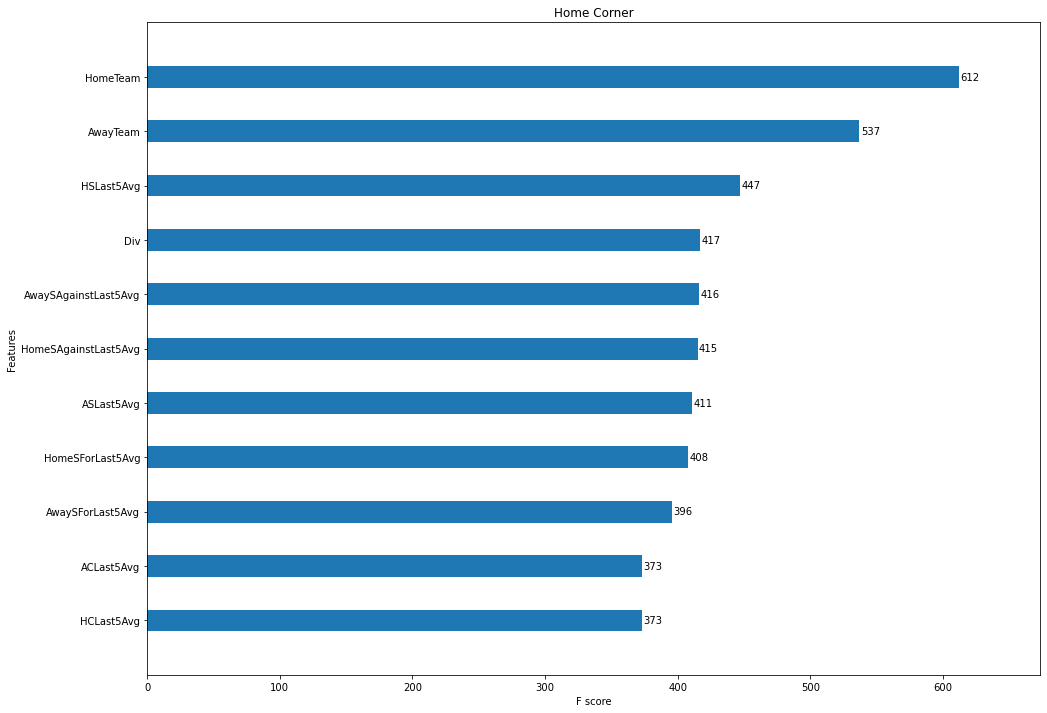

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

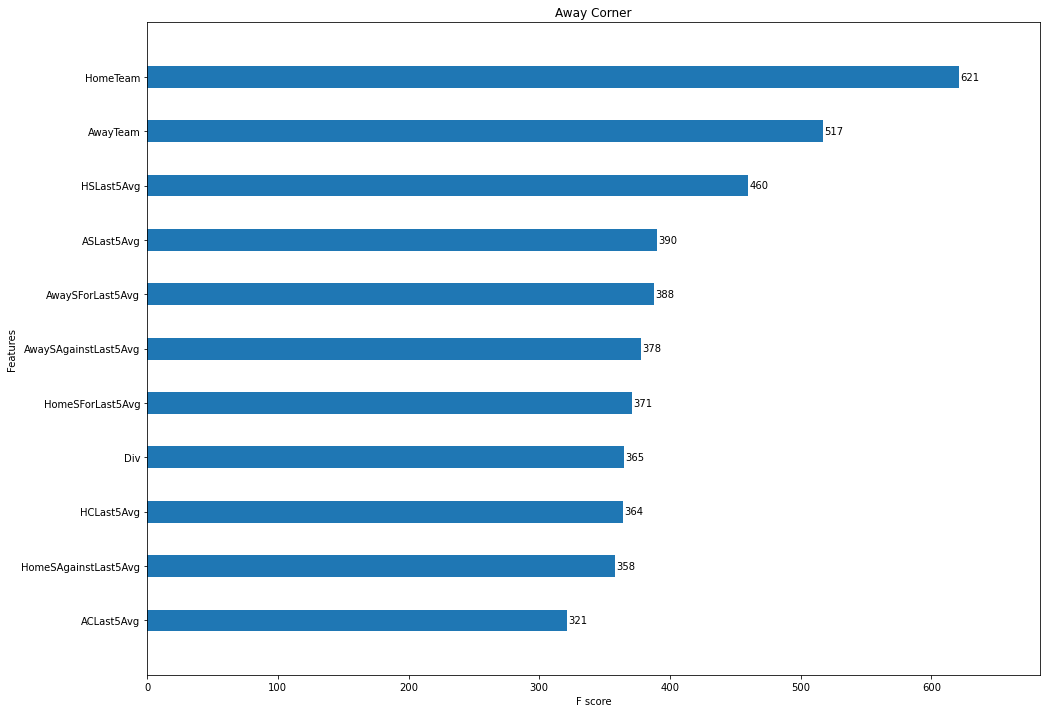

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [41]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC
0,I1,Benevento,Milan,7.0,4.0,9.400000,5.8,8.600000,10.6,6.2,9.2,12.0,4.0
1,SP1,Betis,Villarreal,14.2,6.0,9.600000,3.8,13.800000,10.8,10.2,10.2,1.0,5.0
2,SP1,Alaves,Granada,12.0,5.2,9.600000,3.2,9.000000,8.0,10.2,12.8,6.0,1.0
3,E1,Huddersfield,Burnley,9.4,4.8,12.400000,5.0,9.200000,12.2,13.6,15.2,1.0,5.0
4,F1,Strasbourg,Nice,14.2,5.6,16.200001,6.8,10.600000,17.6,11.2,11.8,2.0,3.0
5,SP2,Numancia,La Coruna,14.8,5.2,9.400000,3.2,13.200000,10.4,12.4,12.8,4.0,7.0
6,F1,Lyon,Strasbourg,10.6,6.0,11.200000,5.4,13.200000,13.0,10.0,9.4,3.0,2.0
7,I2,Venezia,Ascoli,14.6,6.0,12.600000,5.2,16.200001,13.8,9.4,17.0,4.0,3.0
8,SP2,Mirandes,Albacete,13.4,4.6,7.800000,2.0,8.400000,8.8,10.2,15.2,7.0,5.0
9,I2,Ascoli,Spal,13.4,3.2,12.000000,4.2,13.400000,21.0,14.8,10.8,4.0,3.0


In [42]:
learn = tabular_learner(dls, layers=[240, 120])

In [43]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(279, 37)
    (2): Embedding(279, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [44]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.0012022644514217973)

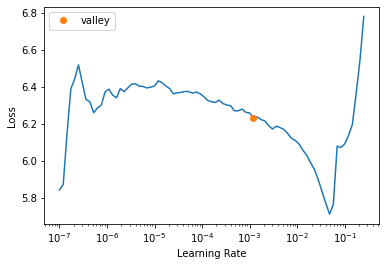

In [45]:
learn.lr_find()

In [46]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,2.547605,2.439873,00:02
1,2.407464,2.417951,00:02
2,2.363660,2.400869,00:02
3,2.334708,2.392673,00:02
4,2.298698,2.398767,00:02


In [47]:
df.query('Season==22 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3929,4.0,6.0


In [48]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [49]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [50]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(3.8254) tensor(3.8254)
tensor(5.9810) tensor(5.9810)


In [51]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [52]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [53]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [54]:
prob_lo, prob_hi

(tensor(0.6073), tensor(0.3927))

## Negative Binomial

In [55]:
y_names = ['HC', 'AC', 'weight']
y_block = RegressionBlock(n_out=5)

In [56]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [57]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,SP2,Girona,Las Palmas,15.200000,4.6,11.4,5.2,10.8,10.6,10.800000,8.8,3.0,6.0,0.658325
1,F2,Valenciennes,Grenoble,9.200000,3.8,11.2,6.2,6.6,12.0,14.600000,10.6,2.0,9.0,0.866764
2,E0,Norwich,Watford,14.000000,4.6,10.8,4.4,8.8,9.6,17.800000,13.6,4.0,8.0,0.980492
3,E1,Hull,Birmingham,13.200000,5.6,10.0,2.8,14.0,12.0,12.400000,9.8,10.0,2.0,1.014930
4,SP2,Levante,Lugo,13.600000,6.6,6.6,3.2,11.6,9.6,11.200000,14.8,17.0,3.0,1.308025
5,I2,Ternana,Benevento,16.399999,5.0,14.4,5.8,13.0,18.0,16.799999,11.4,6.0,6.0,1.026114
6,E1,Brentford,Fulham,16.200001,6.4,10.4,4.0,15.2,14.8,7.800000,15.2,10.0,3.0,0.688956
7,E0,West Ham,Crystal Palace,10.200000,4.4,9.0,4.8,14.2,10.2,12.600000,14.2,5.0,3.0,0.969274
8,F2,Rodez,Amiens,12.200000,5.0,9.0,3.2,13.0,11.0,11.000000,10.6,8.0,2.0,1.206137
9,I2,Brescia,Reggina,16.799999,8.8,8.4,3.6,13.8,9.0,9.800000,14.8,13.0,2.0,1.112185


In [58]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [59]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(279, 37)
    (2): Embedding(279, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [60]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.018045615404844284)

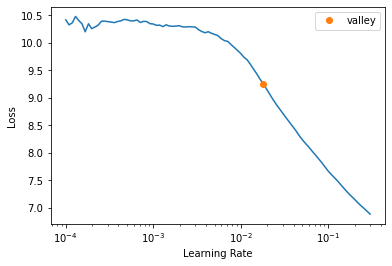

In [61]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [62]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.826580,6.942898,00:02
1,4.573837,6.908789,00:02
2,4.563717,6.883068,00:02
3,4.486659,6.871476,00:02
4,4.429798,6.879460,00:02


In [63]:
df.query('Season==22 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3896,3.0,2.0


In [64]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [67]:
_, params = learn_bnb.predict(df.query('Season==22 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [68]:
params

tensor([ -2.4573,  -2.4531,   3.3677,   6.9140, -36.1198])

In [69]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = params[4]
# omega = torch.tanh(params[4]) * 50.

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.0822, 0.0825]) tensor([3.4016, 6.9150]) tensor(-36.1198)


In [70]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [71]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.4016, 6.9150]) tensor([ 4.3526, 10.8612])


In [72]:
# Method 1:
corr = omega * torch.sqrt(mu.prod()) * alpha.prod() / ((1.+alpha)**(1./alpha+1.)).prod() / torch.sqrt((1.+alpha*mu).prod())
corr 

tensor(-0.1047)

In [73]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
# corr 

In [74]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [75]:
corner = bnb_corner.log_prob(value).exp()

In [76]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [77]:
prob_lo, prob_hi

(tensor(0.5510), tensor(0.4490))

In [78]:
1/prob_lo, 1/prob_hi

(tensor(1.8148), tensor(2.2273))

### Train full model

In [79]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [80]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,SP1,Barcelona,Real Madrid,14.800000,6.4,13.8,5.4,12.000000,18.399999,12.000000,8.600001,8.0,1.0,1.323163
1,I1,Juventus,Bologna,13.400000,6.0,7.8,1.8,14.200000,9.800000,9.200000,16.799999,4.0,5.0,1.100063
2,F1,Marseille,Auxerre,17.799999,5.2,9.2,2.6,16.000000,10.600000,9.600000,13.400000,12.0,1.0,1.353967
3,E0,Chelsea,Leicester,19.200001,8.6,11.8,4.2,17.799999,13.200000,9.600000,11.600000,4.0,5.0,0.645820
4,I1,Napoli,Udinese,16.799999,7.2,8.4,7.6,14.400000,9.200000,6.600000,10.000000,2.0,3.0,0.776371
5,E2,Ipswich,Morecambe,10.400000,5.4,10.2,5.0,12.000000,10.800000,13.000000,12.400000,10.0,3.0,0.958185
6,I2,Sudtirol,Spal,10.600000,4.8,10.8,4.4,9.400000,12.600000,16.200001,14.800000,6.0,4.0,1.322438
7,E2,Oxford,Blackpool,12.200000,6.4,10.8,4.4,15.600001,10.400000,8.800000,12.000000,3.0,7.0,0.707705
8,SP1,Real Madrid,Cadiz,13.400000,4.4,5.8,2.6,12.400000,9.400000,11.600000,10.000000,4.0,11.0,0.815617
9,SP2,Numancia,Mirandes,10.000000,4.4,11.0,3.0,8.399999,10.000000,11.600000,14.500000,6.0,1.0,0.650436


In [81]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [82]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(279, 37)
    (2): Embedding(279, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [83]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.018045615404844284)

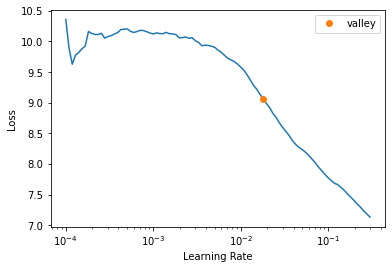

In [84]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [85]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.845701,None,00:02
1,4.684969,None,00:02
2,4.660080,None,00:02
3,4.595986,None,00:02
4,4.559174,None,00:02


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [86]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [87]:
to.export('models/to.pkl')

### t-SNE

In [88]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Alaves', 'Albacete',
       'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta',
       'Andorra', 'Angers', 'Annecy', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Bari', 'Barnsley', 'Bastia', 'Bayern Munich',
       'Benevento', 'Betis', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Braunschweig', 'Brentford', 'Brescia', 'Brest',
       'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley',
       'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff',
       'Carlisle', 'Cartagena', 'Castellon', 'Catanzaro', 'Celta',
       'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham',
       'Chievo', 'Cittadella', 'Clermont', 'Como', 'Concarneau',
       'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone',
       'Crystal Palace', 'Darmstadt', 'D

In [89]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Alaves', 'Albacete',
       'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta',
       'Andorra', 'Angers', 'Annecy', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Bari', 'Barnsley', 'Bastia', 'Bayern Munich',
       'Benevento', 'Betis', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Braunschweig', 'Brentford', 'Brescia', 'Brest',
       'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley',
       'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff',
       'Carlisle', 'Cartagena', 'Castellon', 'Catanzaro', 'Celta',
       'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham',
       'Chievo', 'Cittadella', 'Clermont', 'Como', 'Concarneau',
       'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone',
       'Crystal Palace', 'Darmstadt', 'D

In [90]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 278
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Andorra', 'Angers', 'Annecy', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Bari', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Carlisle', 'Cartagena', 'Castellon', 'Catanzaro', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Concarneau', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Dunkerque', 'Eibar', 'Ein Fra

In [91]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

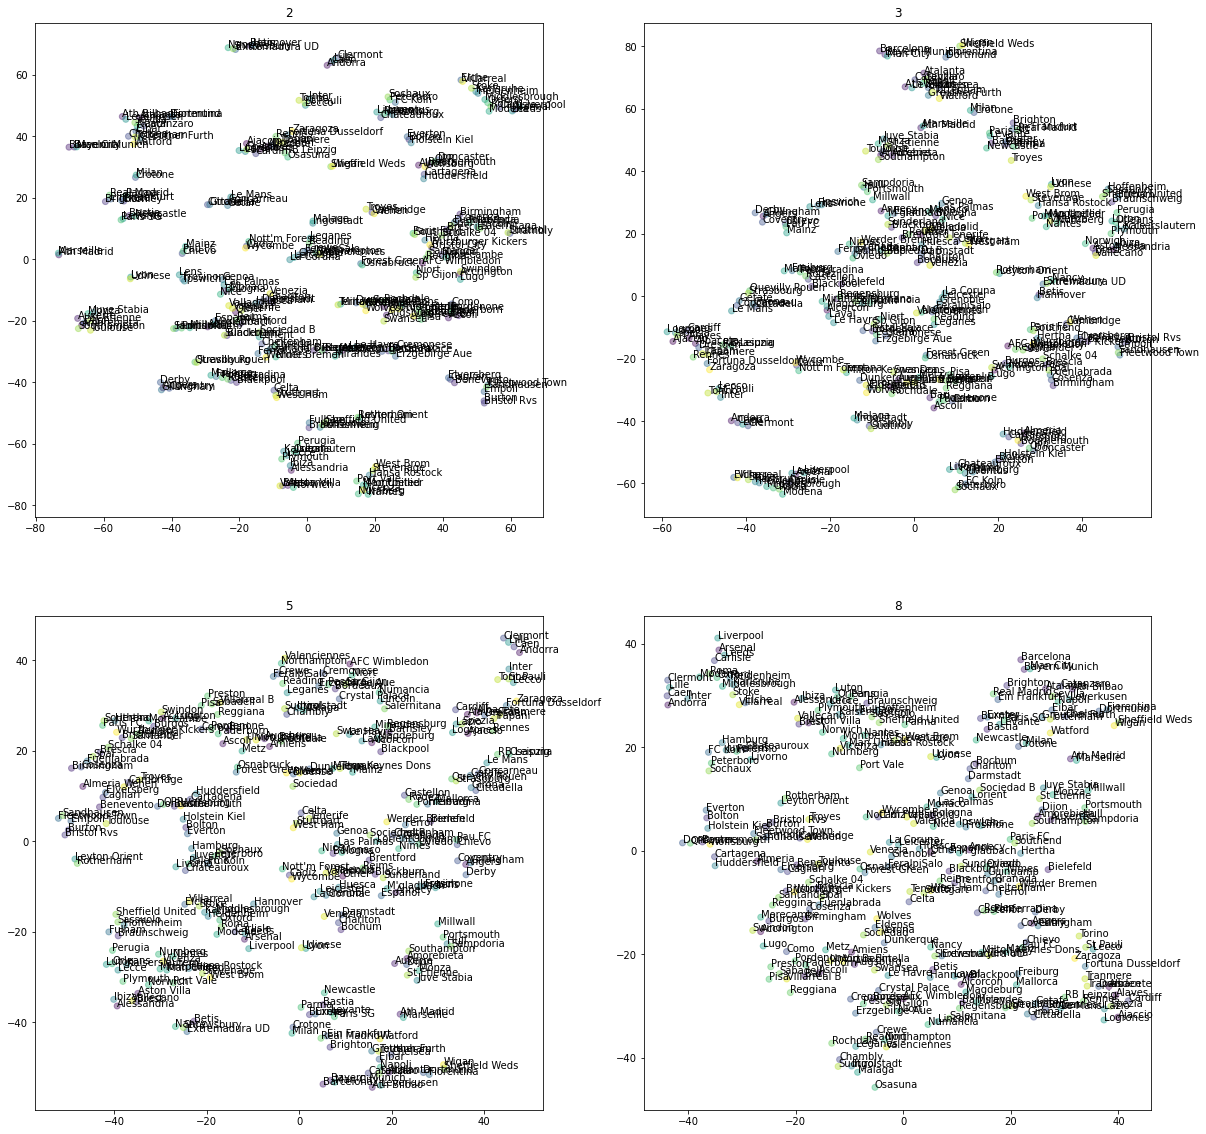

In [92]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END